<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Image-Retrieval/Custom_Made_Face_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn tensorflow opencv-python matplotlib

Load and Preprocess the LFW Dataset

Number of samples: 1288
Image shape: (50, 37)
Number of classes: 7


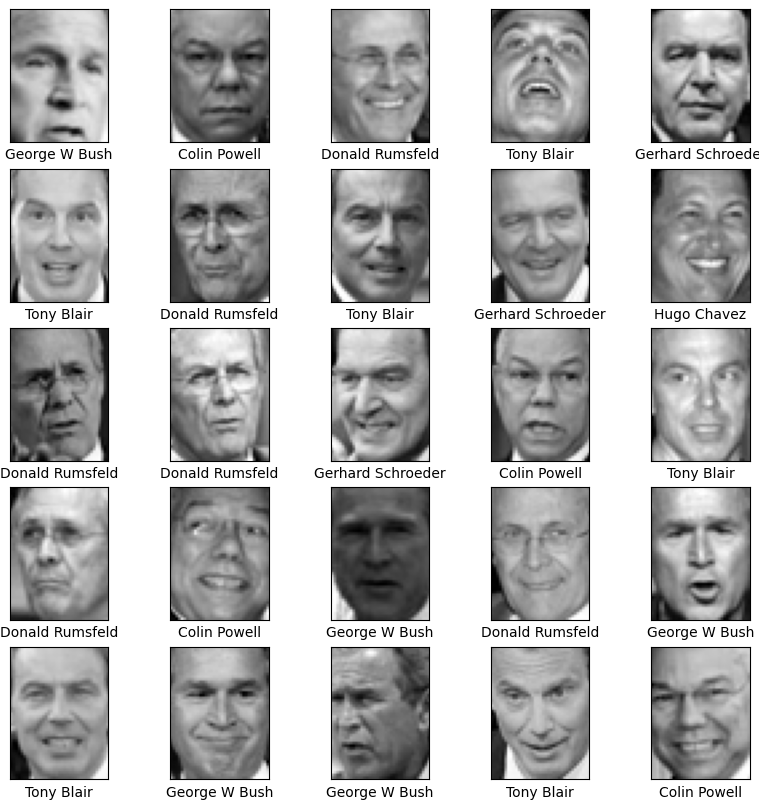

In [4]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Dataset information
print("Number of samples:", lfw_people.images.shape[0])
print("Image shape:", lfw_people.images.shape[1:])
print("Number of classes:", len(lfw_people.target_names))

# Extract images and labels
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

# Normalize pixel values to [0, 1] Convert images to float32 to avoid numerical precision issues
X = X.astype('float32') / 255.0

# Add a channel dimension for CNN
X = X[..., np.newaxis]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Visualize some samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.xlabel(target_names[y_train[i]])  # Fixed error
plt.show()


Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

CNN Model buiding

In [8]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model  # Fixed indentation

# Build the model
input_shape = X_train.shape[1:]
num_classes = len(target_names)
model = build_model(input_shape, num_classes)

# Compile model
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=True)  # Fixed deprecated 'lr'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 37, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 9, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 9, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 9, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,130,631 (11.94 MB)

 Trainable params: 3,128,711 (11.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

Training

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)  # Compute statistics for normalization if needed

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 599ms/step - accuracy: 0.2705 - loss: 7.6293 - val_accuracy: 0.4534 - val_loss: 24.8524 - learning_rate: 0.0100
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.4266 - loss: 1.8269 - val_accuracy: 0.4534 - val_loss: 7.1605 - learning_rate: 0.0100
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 576ms/step - accuracy: 0.3994 - loss: 1.7614 - val_accuracy: 0.4534 - val_loss: 4.6423 - learning_rate: 0.0100
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 595ms/step - accuracy: 0.4111 - loss: 1.7087 - val_accuracy: 0.4534 - val_loss: 3.1291 - learning_rate: 0.0100
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.3896 - loss: 1.7193 - val_accuracy: 0.4534 - val_loss: 2.2988 - learning_rate: 0.0100
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.4100 - loss: 1.6913 - val_accuracy: 0.4534 - val_loss: 1.9315 - learning_rate: 0.0100
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 576ms/step - accuracy: 0.4055 - loss: 1.7113 - val

Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Predict on test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Save and Load Model

In [ ]:
# Save the model
model.save("lfw_face_recognition_model.h5")

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model("lfw_face_recognition_model.h5")

Visualize trainning Progress

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model Testing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files  # Use this if running in Google Colab

# Upload an image (if using Google Colab)
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded image filename

# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (37, 50))  # Resize to match LFW dataset (width=37, height=50)
    img = img.astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Preprocess and predict
image = preprocess_image(image_path)
prediction = model.predict(image)
predicted_class = np.argmax(prediction)

# Display the result
plt.imshow(cv2.imread(image_path), cmap='gray')
plt.axis('off')
plt.title(f"Predicted: {target_names[predicted_class]}")
plt.show()
